## Общее описание:

В данном эксперименте мы проверяем, действительно ли
новая система рекомендаций товаров сможет принести пользу бизнесу.

Чтобы это проверить, был проведен АБ-тест.

В группе 1 оказались пользователи с новой системой рекомендаций,
в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

 

## Описание данных
Данные состоят из логов заказов пользователей:

1)  <b>ab_users_data</b> - история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
<br><br>
2) <b>ab_orders</b> - подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
<br><br>
3) <b>ab_products</b> - подробная информация о продуктах, их название и стоимость



### План

**1. Планирование эксперимента: выбираем метрики, формулируем гипотезы эксперимента** 

**2. Подготовка к работе. Импорт необходимых библиотек и загрузка данных**
   
**3. Изучение данных**

**4. Выбор и проведение теста. Формулирование выводов**




<hr style="border:1px solid">

## 1. Планирование эксперимента: выбираем метрики, формулируем гипотезы эксперимента

<u>Нулевая гипотеза эксперимента</u> - новая система рекомендаций смогла принести пользу бизнесу в форме увеличения прибыли.

<br>
<u>Альтернативная гипотеза эксперимента</u> - новая система рекомендаций не смогла принести пользу бизнесу и существенно не повысила прибыль компании.

Главной (целевой) метрикой, на которую будем ориентироваться, будем считать среднее суммы покупок (в рублях) у каждого из пользователей.
    
MDE этой метрики - возможность засечь увеличение суммы трат каждого из пользователей в среднем на 20 рублей.
    

Второй метрикой будем считать отношение кол-ва заказов, не отмененных в дальнейшем, к общему кол-ву сделанных заказов.
    
MDE этой метрики - возможность засечь снижение доли отмененных заказов в рамках новой рекомендации на 2%.  
    
Третьей метрикой будем считать кол-во товаров в рамках каждого заказа, приобретаемых каждым из пользователей.
    
MDE этой метрики - возможность засечь увеличение кол-ва товаров в рамках заказа на 1 позицию.  
    
</b>




<hr style="border:1px solid">

## 2.  Импорт необходимых библиотек. Загрузка и изучение данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import pingouin as pg
import statistics
import numpy as np
from scipy.stats import norm
%matplotlib inline


In [2]:
# Устанавливаем общие настройки для графиков

sns.set(
rc={
    'figure.figsize':(46,15)
},
font_scale=2
)

### 2.1. Загружаем и изучаем  данные об истории заказов пользователей

In [3]:
# Загружаем данные

users_data = pd.read_csv('../ab_users_data.csv')

In [4]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [5]:
# Смотрим размер данных

users_data.shape

(4337, 6)

In [93]:
# проверяем данные на наличие пропусков 

users_data.isna().sum()



user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [7]:
# Проверяем данные на наличие повторяющихся строк

users_data.loc[users_data.duplicated()]

,user_id,order_id,action,time,date,group


In [8]:
# Смотрим на типы данных

users_data.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [9]:
# Преобразовываем столбцы time и date (время заказов) к типу данных datetime

users_data[['time','date']] = users_data[['time','date']].apply(pd.to_datetime)


In [10]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [11]:
# Смотрим какие есть виды действий у пользователей

users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [12]:
# Смотрим на кол-во пользователей в А и B группах

number_of_users = users_data.groupby('group').agg({'user_id':'nunique'})



In [13]:
number_of_users

,user_id
group,
0,515
1,502


<b>Видим, что в контрольной и тестовой группе кол-во пользователей примерно равное</b>

### 2.2. Загружаем  и изучаем данные о составе заказа

In [14]:
# Загружаем данные

orders = pd.read_csv('./ab_orders.csv')

In [15]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [16]:
# Смотрим размер данных

orders.shape

(4123, 3)

In [17]:
# Проверяем данные на наличие пропусков 

orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [18]:
# Проверяем данные на наличие повторяющихся строк

orders.loc[orders.duplicated()]

,order_id,creation_time,product_ids


In [19]:
# Смотрим на типы данных

orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [20]:
# Преобразовываем столбец creation_time (дата создания заказа) к типу данных datetime

orders['creation_time'] = pd.to_datetime(orders['creation_time'])



<b>
Для дальнейшего сравнения разницы в кол-ве товаров, которое приходится на каждый заказ, в тестовой и контрольной
<br> группах, необходимо привести значения в столбце product_ids в более удобный формат.
</b>

In [21]:
# Транфсформируем фигурные скобки в квадратные, чтобы в дальнейшем сделать массив из id товаров в заказе

orders['product_ids'] = orders['product_ids'].str.replace('{','').str.replace('}','').str.split(', ')

In [22]:
def x(y):
    l = []
    for el in y:
        el = int(el)
        l.append(el)
    return l

In [23]:
orders['product_ids'] = orders['product_ids'].apply(x)

In [24]:
orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"[74, 6]"
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]"
...,...,...,...
4118,59422,2022-09-08 23:13:03,"[84, 8, 24]"
4119,59439,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]"
4120,59464,2022-09-08 23:22:27,"[60, 41, 46]"
4121,59487,2022-09-08 23:29:06,"[9, 62, 77]"


In [25]:
# Применяем функцию explode, чтобы преобразовать каждый элемент в списке товаров в отдельную строку 
# и переименовываем product_ids в product_id

orders = orders.explode('product_ids').reset_index(drop=True).rename(columns={'product_ids':'product_id'})

In [26]:
orders.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19,75
1,1255,2022-08-26 00:00:19,22
2,1255,2022-08-26 00:00:19,53
3,1255,2022-08-26 00:00:19,84
4,1256,2022-08-26 00:02:21,56


### 2.3. Загружаем и изучаем данные о продуктах, их названии и стоимости

In [27]:
products = pd.read_csv('./ab_products.csv')

In [28]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [29]:
# Смотрим размер данных

products.shape

(87, 3)

In [30]:
# Проверяем данные на наличие пропусков 

products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [31]:
# Проверяем данные на наличие повторяющихся строк

products.loc[products.duplicated()]

,product_id,name,price


In [32]:
# Смотрим на типы данных

products.dtypes

product_id      int64
name           object
price         float64
dtype: object

### 2.4. Объединяем датафреймы в единый датафрейм

<b> Для удобства создаем один df из нескольких и при необходимости будем брать те или иные столбцы из него. </b>

In [33]:
full_data = users_data.merge(orders, on='order_id').merge(products, on='product_id')

In [34]:
full_data.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36,2022-08-26,0,2022-08-26 00:31:36,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40,2022-08-26,1,2022-08-26 03:01:40,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22,2022-08-26,1,2022-08-26 04:01:22,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05,2022-08-26,1,2022-08-26 06:04:05,75,сок ананасовый,120.0


<hr style='border: 1px solid'>

## 3. Проводим предварительный анализ данных

### 3.1. Анализируем данные о покупках пользователей

<b>В рамках главной метрики (среднее трат пользователей) нам важно,
<br>чтобы заказ не был отменен в дальнейшем, поскольку при отмене заказа
<br>
по общему правилу деньги возвращаются покупателю.</b>

In [35]:
# Извлекаем из данных данные с отмененными заказами

canceled_ids = full_data.query('action == "cancel_order"')

In [36]:
# Извлекаем список id отмененных товаров

canceled_ids = list(canceled_ids.order_id.unique())

In [37]:
canceled_ids

[2339,
 2472,
 3048,
 4057,
 9760,
 21243,
 2108,
 2253,
 2351,
 3578,
 10868,
 16735,
 20222,
 1298,
 2691,
 30841,
 37121,
 1820,
 5587,
 8974,
 9935,
 10747,
 20810,
 35005,
 2512,
 2628,
 2666,
 2731,
 3370,
 4700,
 7148,
 9481,
 10197,
 17272,
 28749,
 33794,
 34135,
 1707,
 2105,
 2402,
 17506,
 18446,
 20423,
 26481,
 28987,
 40498,
 46468,
 47115,
 49421,
 53610,
 1406,
 1427,
 14012,
 51564,
 1620,
 1623,
 2190,
 2310,
 3467,
 6505,
 9409,
 13640,
 13957,
 20685,
 56612,
 1417,
 6346,
 1319,
 2314,
 4915,
 31483,
 48882,
 1258,
 1606,
 1805,
 2674,
 2699,
 10577,
 14868,
 19924,
 29502,
 30526,
 36236,
 59055,
 1632,
 1729,
 4208,
 4578,
 6209,
 9135,
 14244,
 14294,
 28722,
 45541,
 53634,
 13724,
 9621,
 49921,
 56772,
 1544,
 1723,
 1827,
 2182,
 2561,
 17615,
 26678,
 26880,
 47014,
 54938,
 1610,
 1612,
 2275,
 7746,
 8669,
 11093,
 41109,
 51612,
 1308,
 2101,
 12043,
 22847,
 34167,
 38725,
 1296,
 1344,
 3110,
 3659,
 13162,
 15961,
 21293,
 47952,
 48427,
 1509,
 4903

In [38]:
# Создаем новый df с условием, что id отмененных товаров не будет в новом df

purchases_data = full_data.query('order_id not in @canceled_ids')

In [39]:
# Данный df содержит информацию о заказах, не отмененных в дальнейшем

purchases_data.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36,2022-08-26,0,2022-08-26 00:31:36,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40,2022-08-26,1,2022-08-26 03:01:40,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22,2022-08-26,1,2022-08-26 04:01:22,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05,2022-08-26,1,2022-08-26 06:04:05,75,сок ананасовый,120.0


In [40]:
purchases_data.shape

(13083, 10)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


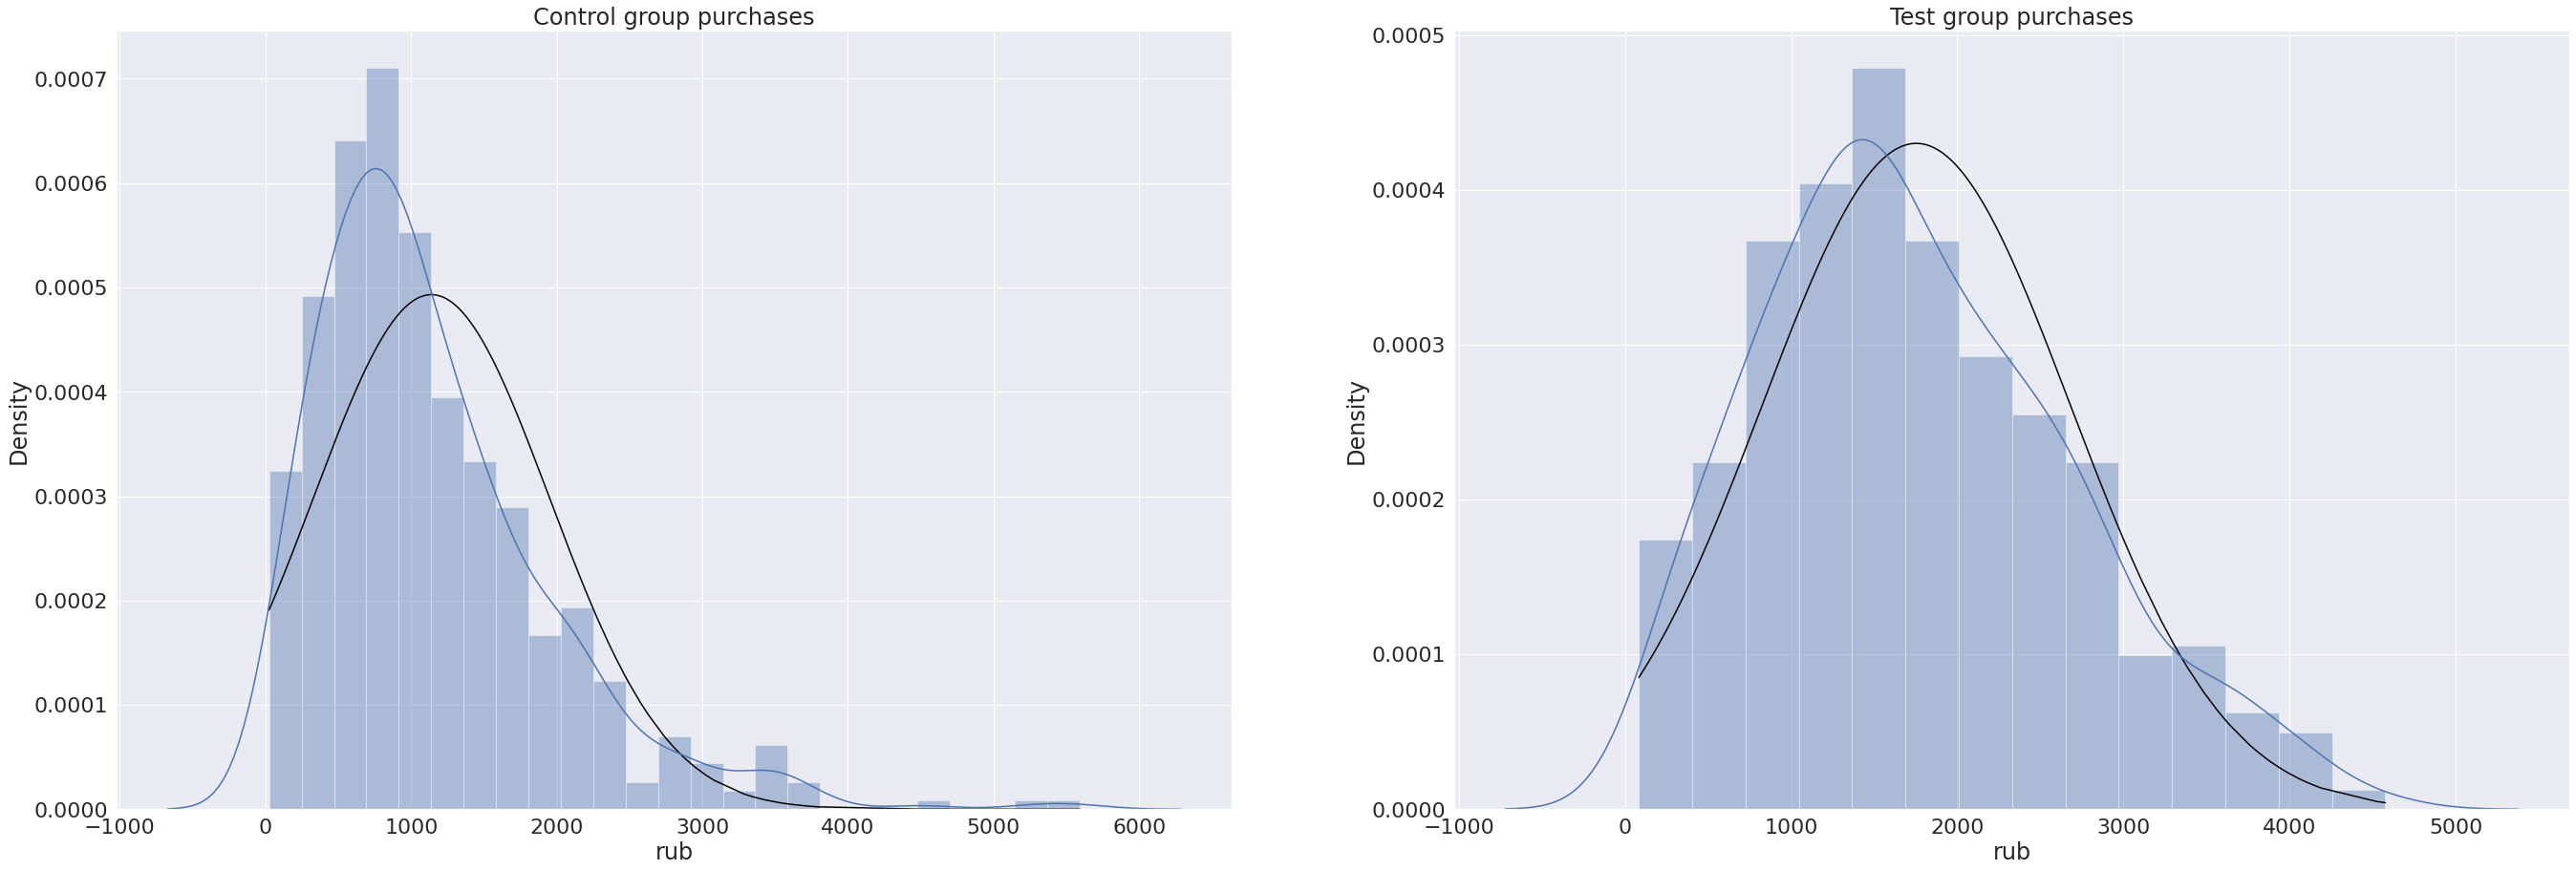

In [41]:
# Визуализируем наши данные по покупкам - строим гистограммы распределения сумм заказов пользователей в двух группах
# и поверх них линии нормального распределения

purchases_data_control = purchases_data.query('group == 0')[['user_id','price']].groupby('user_id') \
.agg({'price':'sum'})
purchases_data_test = purchases_data.query('group == 1')[['user_id','price']].groupby('user_id') \
.agg({'price':'sum'})


plt.subplot(1, 2, 1) 
control_mean = np.mean(purchases_data_control.price)  
control_std = np.std(purchases_data_control.price) 
control_pdf = stats.norm.pdf(purchases_data_control.price.sort_values(), control_mean, control_std)
plt.plot(purchases_data_control.price.sort_values(), control_pdf, color="Black", label="Cultivar_A")

plt.title('Control group purchases')
sns.distplot(purchases_data_control.price)

plt.xlabel('rub')

plt.subplot(1, 2, 2)
test_mean = np.mean(purchases_data_test.price)  
test_std = np.std(purchases_data_test.price) 
test_pdf = stats.norm.pdf(purchases_data_test.price.sort_values(), test_mean, test_std)
plt.plot(purchases_data_test.price.sort_values(), test_pdf, color="Black", label="Cultivar_A")
plt.title('Test group purchases')

sns.distplot(purchases_data_test.price)
plt.xlabel('rub')
plt.show()



<b>Видим, что в обеих группах графики сумм покупок скошены вправо.
<br>Проводим на всякий случай также тест на нормальность распределения данных в обеих группах.
</b>

In [42]:
# Считаем кол-во покупок в тестовой группе

purchases_data_test.price.count()

501

In [43]:
# Проводим тест Шапиро (поскольку кол-во значений менее 5000) по тестовой группе

stats.shapiro(purchases_data_test.price)


ShapiroResult(statistic=0.9748774170875549, pvalue=1.408598961916141e-07)

In [44]:
# Считаем кол-во покупок в контрольной группе

purchases_data_control.price.count()

512

In [45]:
# Для контрольной группы тоже проводим тест Шапиро

stats.shapiro(purchases_data_control.price)

ShapiroResult(statistic=0.88853520154953, pvalue=8.713836969217895e-19)

<b><u>Вывод:</u> Распределения трат по пользователям в обеих группах имеют не нормальный характер, поэтому такие распределения 
    <br>лучше всего будут характеризовать <u>медианы</u> и по разнице между ними мы будем судить об успешности новой рекомендации товаров.
</b>

In [46]:
# Вычисляем медиану покупок в контрольной группе

control_median = purchases_data_control.price.median()

In [47]:
control_median

955.6999999999999

In [48]:
# Вычисляем медиану покупок в тестовой группе

test_median = purchases_data_test.price.median()

In [49]:
test_median

1630.1

<b>Видим, что различия в медианных значениях существенны в пользу тестовой группы (на 675 единиц). С помощью теста будем проверять, действительно ли такие различия стат. значимы.</b>

### 2.2. Анализируем  данные об истории заказов пользователей

<b> Вторая метрика - отношение кол-ва заказов, не отмененных в дальнейшем, к общему кол-ву сделанных заказов. Для подсчета значений метрики в двух группах будем использовать ранее созданный нами df "purchases_data", содержащий id не отмененных в дальнейшем заказов. </b>

In [50]:
# Считаем, сколько полноценных (не отмененных) заказов сделано в контрольной и тестовой группах

not_canceled_orders = purchases_data.groupby('group', as_index=False) \
.agg({'order_id':'nunique'})  \
.rename(columns={'order_id':'number_of_orders'})

In [51]:
not_canceled_orders

,group,number_of_orders
0,0,1527
1,1,2382


In [52]:
# Считаем, сколько всего заказов сделано в контрольной и тестовой группах

all_orders = full_data.groupby('group', as_index=False) \
.agg({'order_id':'nunique'}) \
.rename(columns={'order_id':'number_of_orders'})

In [53]:
all_orders

,group,number_of_orders
0,0,1609
1,1,2514


In [54]:
# Создаем объединенный df на основе двух созданных выше

merged_orders_data = not_canceled_orders.merge(all_orders, on='group', suffixes=('_not_canceled', '_all'))

In [55]:
merged_orders_data

,group,number_of_orders_not_canceled,number_of_orders_all
0,0,1527,1609
1,1,2382,2514


In [56]:
merged_orders_data['number_of_orders_not_canceled'][0]

1527

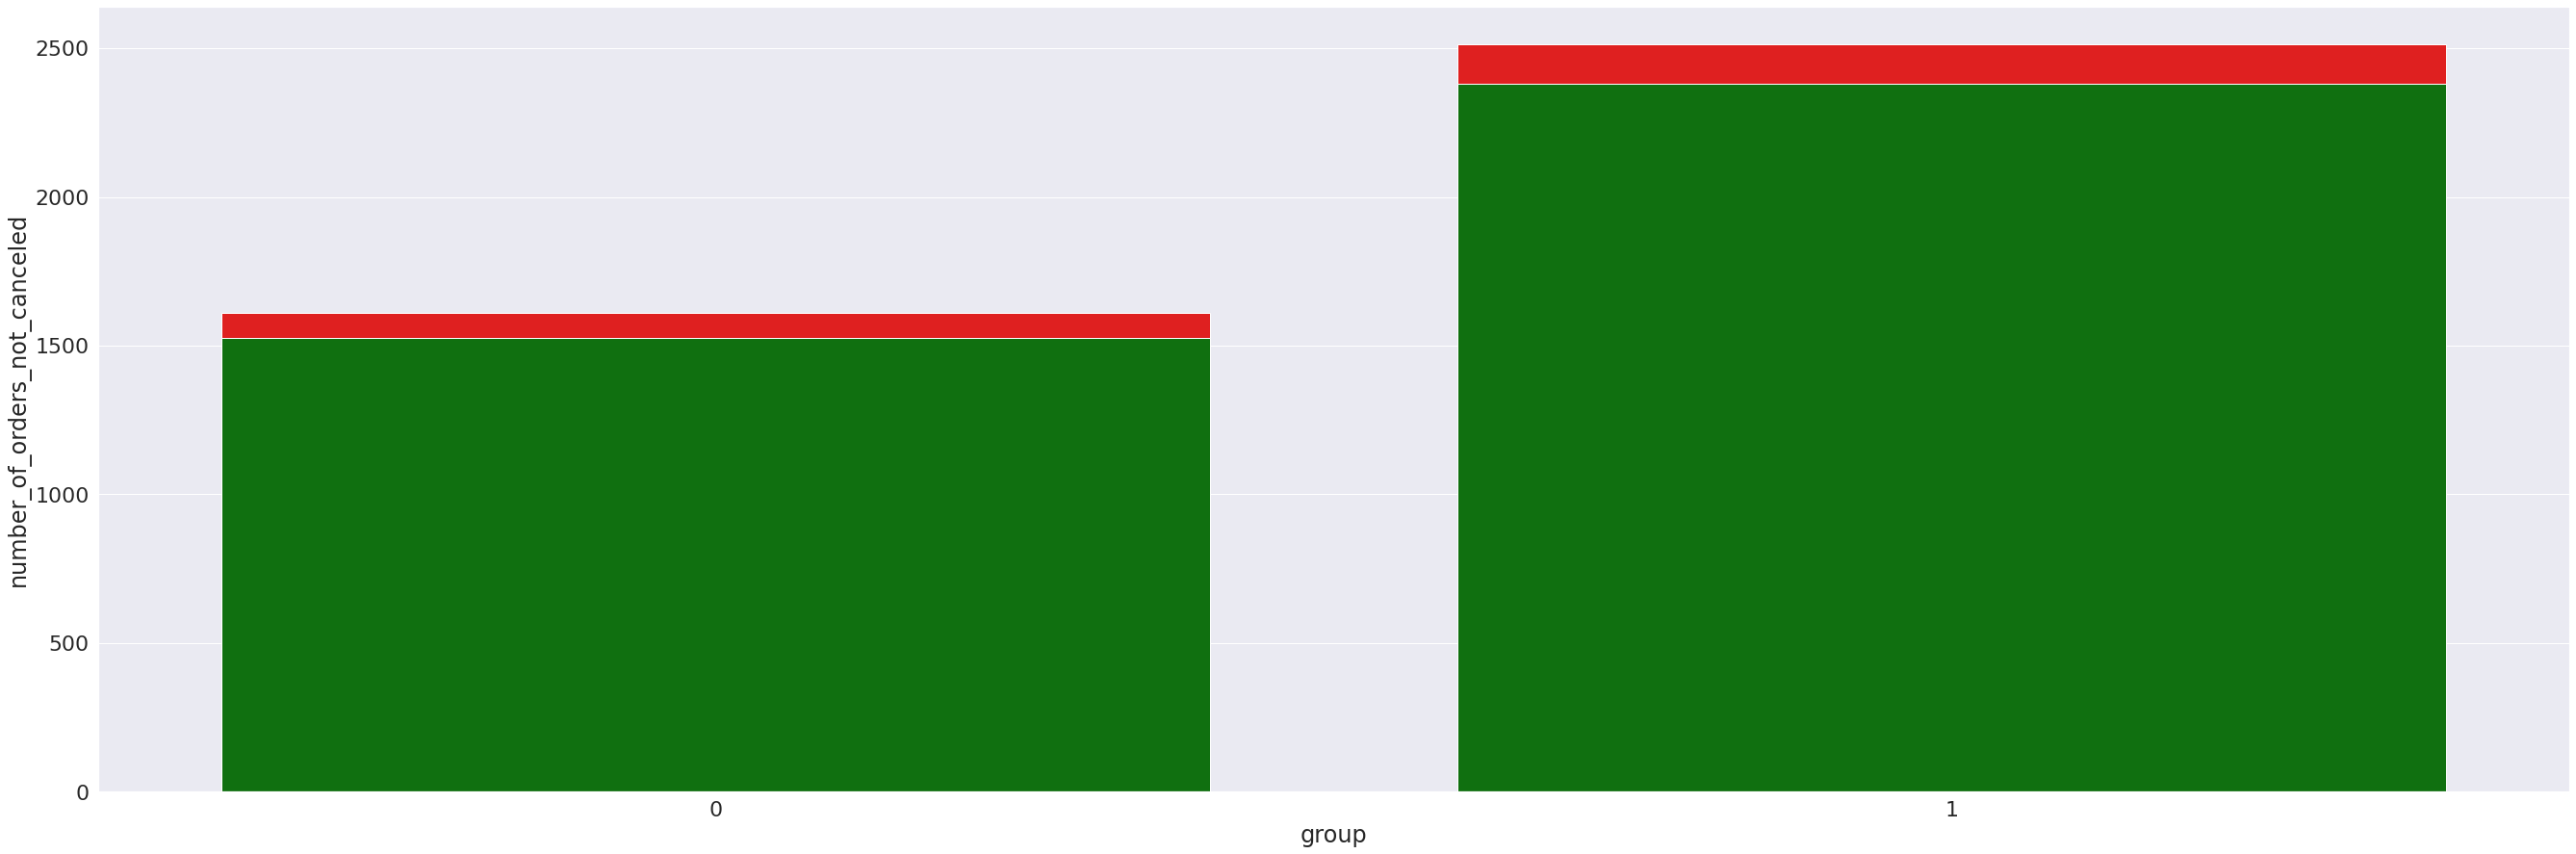

In [57]:
# Визуализируем данные 

sns.barplot(data=merged_orders_data, x='group',y='number_of_orders_all', color='red')
sns.barplot(data=merged_orders_data, x='group',y='number_of_orders_not_canceled', color='green')
plt.show()

<b> Наблюдаем значительное превышение кол-ва сделанных заказов в тестовой
группе по сравнению с контрольной в абсолютных значениях. 
<br><br>
Теперь необходимо выявить разницу в соотношениях/пропорциях не отмененных в дальнейшем заказов ко всем заказам между двумя группами
и далее проводить тест на стат. значимость в разнице.
</b>


In [82]:
# Считаем пропорции сделанных заказов (не отмененных в дальнейшем) к общему кол-ву заказов 
# в контрольной групе

proportion_control =  ((merged_orders_data['number_of_orders_not_canceled'][0] / \
                        merged_orders_data['number_of_orders_all'][0]) * 100).round(2)

In [83]:
proportion_control

94.9

In [84]:
# Считаем пропорции сделанных заказов (не отмененных в дальнейшем) к общему кол-ву заказов 
# в тестовой групе

proportion_test = ((merged_orders_data['number_of_orders_not_canceled'][1] / \
                    merged_orders_data['number_of_orders_all'][1]) * 100).round(2)

In [85]:
proportion_test

94.75

<b>Разница в пропорциях не отмененных заказов ко всем между двумя группами - 0.15% в пользу контрольной группы</b>

### 2.3. Проводим анализ данных о продуктах, добавленных в заказ

<b>Для нашей третьей метрики (среднее кол-во товаров в корзине/заказе у каждого покупателя) нам необходимо в каждой группе у каждого покупателя посчитать кол-во добавленных в заказ товаров и сравнить показатели.
<br><br> При этом мы будем учитывать кол-во товаров в тех заказах, которые в дальнейшем не были отменены.
</b>

In [62]:
# На основе df "purchases_data" с неотмененными заказами считаем кол-во товаров в
# каждом заказе у каждого покупателя в контрольной группе.

products_control = purchases_data.query('group == 0') \
.groupby(['user_id','order_id'], as_index=False) \
.agg({'product_id':'count'}) 

In [63]:
products_control

,user_id,order_id,product_id
0,964,1255,4
1,964,1257,4
2,968,1261,4
3,968,14882,5
4,968,15704,2
...,...,...,...
1522,1973,39705,2
1523,1974,2759,4
1524,1974,4425,5
1525,1974,33164,5


In [64]:
# Считаем кол-во товаров в каждом заказе у каждого покупателя в тестовой группе.

products_test = purchases_data.query('group == 1') \
.groupby(['user_id','order_id'], as_index=False) \
.agg({'product_id':'count'})

In [65]:
products_test

,user_id,order_id,product_id
0,965,1256,3
1,965,3946,4
2,965,9097,6
3,965,9101,3
4,965,10401,4
...,...,...,...
2377,1980,57384,3
2378,1980,57498,4
2379,1980,58430,6
2380,1980,58460,3


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


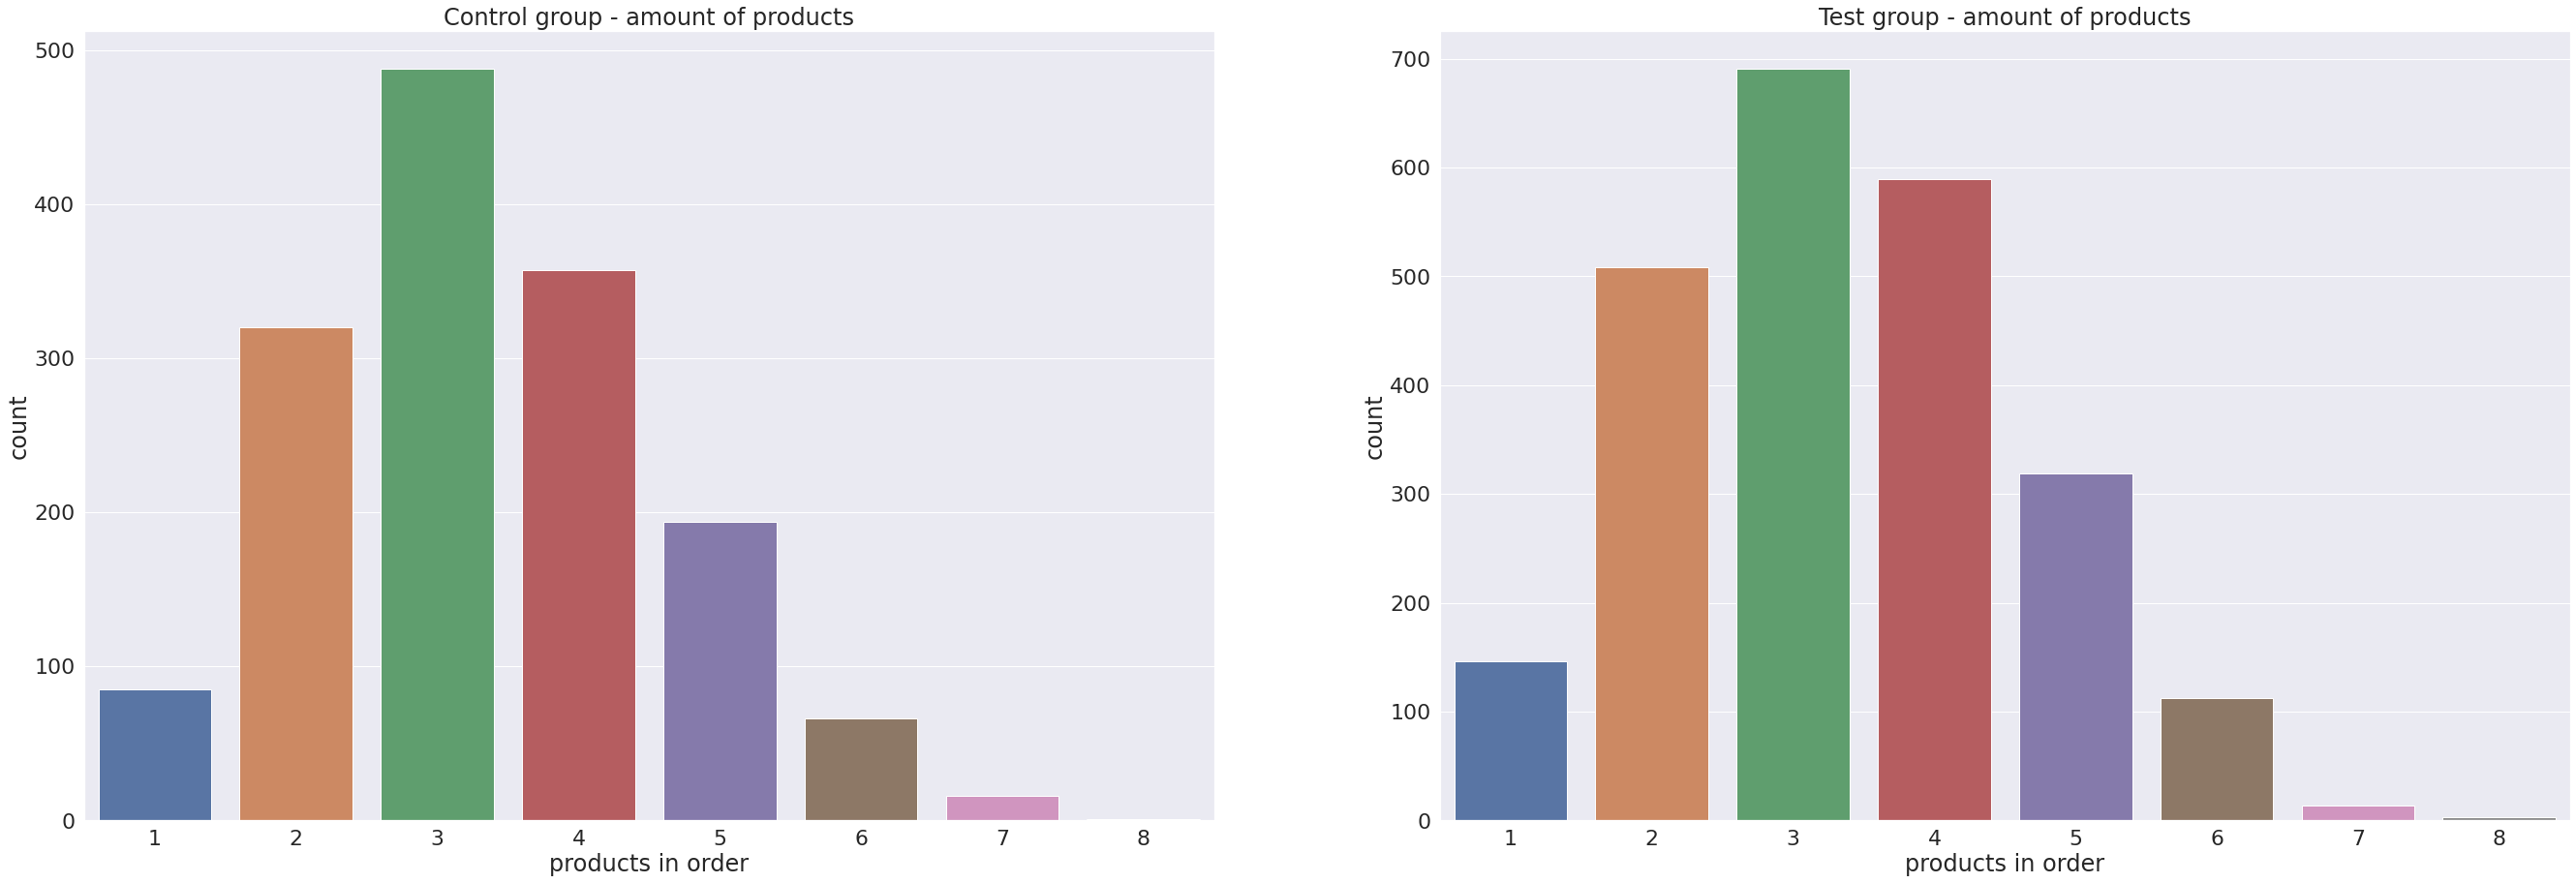

In [66]:
# Строим bar chartы с распределением кол-ва товаров по заказам в контрольной и тестовой группах

plt.subplot(1, 2, 1) 
plt.title('Control group - amount of products')
sns.countplot(products_control.product_id)

plt.xlabel('products in order')

plt.subplot(1, 2, 2)
plt.title('Test group - amount of products')

sns.countplot(products_test.product_id)
plt.xlabel('products in order')
plt.show()

<b>
<br>Видно, что в тестовой группе наблюдается некоторое увеличение по кол-вам товаров
<br> в заказе. Однако, это может и объясняться разными размерами групп.
<br><br>
    Проверяем распределения на нормальность</b>

In [67]:
# Используем библиотеку stats и функцию shapiro

stats.shapiro(products_test.product_id)


ShapiroResult(statistic=0.9396564364433289, pvalue=4.2171234113150866e-30)

In [68]:
stats.shapiro(products_control.product_id)

ShapiroResult(statistic=0.9359715580940247, pvalue=4.123595846567559e-25)

<b> Распределения кол-ва товаров по заказам в обеих группах не нормальные
<br><br>
Поскольку распределения не нормальные в обеих группах, лучше всего возможное увеличение кол-ва товаров в заказе будет отражать медианное значение. 

</b>

In [69]:
# Подсчитываем медианное значение кол-ва товаров в контрольной группе

products_control_median = products_control.product_id.median()

In [70]:
products_control_median

3.0

In [71]:
# Подсчитываем  медианное значение кол-ва товаров в тестовой группе

products_test_median = products_test.product_id.median()

In [72]:
products_test.product_id.median()

3.0

<b>Как видно, предварительно, разницы в медианных значениях кол-ва товаров по заказам не наблюдается

<hr style='border:1px solid'>

## 4. Выбираем  и проводим тесты.

### 4.1. Проводим тест на наличие стат. значимой разницы трат пользователей в контрольной и тестовой группах

<b>Нас интересует наличие стат. значимых различий в медианных значениях двух групп. Данные (деньги/рубли) - непрерывные.
<br><br>
H0 : Новая рекомендация товаров статистически не увеличивает медианное значение трат пользоватателей.
<br>
H1 :  Новый алгоритм статистически увеличивает медианное значение трат пользоватателей.
<br>    
    
В качестве теста выбираем бутстрап.</b>

<b>1) Считаем доверительный интервал для медианы в контрольной группе</b>

In [73]:

medians_control = []


for i in range(10000):
    
    sample_data = purchases_data_control.price.sample(frac=1, replace=True)

    
    sample_median = sample_data.median()

    
    medians_control.append(sample_median)


In [74]:
pd.Series(medians_control).quantile(0.025)



880.4

In [75]:
pd.Series(medians_control).quantile(0.975)

1025.6999999999998

<b>95% доверительный интервал, в который попадает медианное значение трат
<br>в контрольной группе - [880-1025].
 
</b>

<b>2) Считаем доверительный интервал для медианы в тестовой группе</b>

In [76]:

medians_test = []


for i in range(10000):
    
    sample_data = purchases_data_test.price.sample(frac=1, replace=True)

    
    sample_median = sample_data.median()

    
    medians_test.append(sample_median)

In [77]:
pd.Series(medians_test).quantile(0.025)

1517.6000000000004

In [78]:
pd.Series(medians_test).quantile(0.975)

1713.6

<b>95% доверительный интервал, в который попадает медианное значение трат
<br>в тестовой группе - [1518-1713].
 
</b>

<b><u>Вывод по итогу теста:</u> медианное значение трат пользоваталей в рамках новой рекомендации товаров 
<br>действительно статистически значимо различается в большую сторону, а именно, как минимум в размере нашего MDE (20 рублей).
<br><br> Следовательно, судя по итогам теста главной метрики, <u>новую рекомендацию товаров нужно выкатывать</u>.    
</b>

### 4.2. Проводим тест на разницу в показателях пропорций сделанных заказов (не отмененных в дальнейшем) к общему кол-ву заказов в контрольной и тестовой группах


<b>Нас интересует наличие стат. значимых различий в пропорциях.
    
В качестве теста выбираем критерий независимости Хи-квадрат Пирсона, который используется,чтобы определить,
зависит ли распределение одной категориальной переменной от другой.
    
В данном случае у нас бинарная переменная (отмененный заказ/не отмененный), которая может по-разному
распределяться в тестовой и контрольной группах.

H0 : Новая рекомендация товаров статистически не снижает долю отмененных заказов.
H1 : Новый алгоритм статистически уменьшает долю отмененных заказов.

Уровень значимости устанавливаем в 0.05 (5%).<b>

In [79]:
# Тест будем проводить на основе созданного нами ранее df с данными о пропорциях не отмененных заказов/всех заказов

merged_orders_data

,group,number_of_orders_not_canceled,number_of_orders_all
0,0,1527,1609
1,1,2382,2514


In [80]:
# Создаем столбец с отмененными заказами

merged_orders_data['canceled_orders'] = merged_orders_data['number_of_orders_all'] - \
merged_orders_data['number_of_orders_not_canceled']

In [81]:
merged_orders_data

,group,number_of_orders_not_canceled,number_of_orders_all,canceled_orders
0,0,1527,1609,82
1,1,2382,2514,132


In [86]:
# Удаляем столбец с суммарным кол-вом заказов, оставляя только отмененные и не отмененные в дальнейшем

merged_orders_data.drop(columns='number_of_orders_all', inplace=True)

In [87]:
merged_orders_data

,group,number_of_orders_not_canceled,canceled_orders
0,0,1527,82
1,1,2382,132


In [88]:
# Создаем таблицу с данными по заказам

table = np.array([[1527, 82],[2382, 132]])

In [90]:
# Проводим тест

res = stats.chi2_contingency(table)

In [92]:
print(f'p-значение - {res[1]}')

p-значение - 0.8840344321879333


<b>Вывод: P-value > 0.05, следовательно, подтверждено, что стат. значимые различия в пропорциях сделанных заказов (не отмененных в дальнейшем) к общему кол-ву заказов в контрольной и тестовой группах отсутствуют. 
<br><br>
Таким образом, по второй метрике различий нет.
</b>

### 4.3. Проводим тест на наличие стат. значимой разницы в кол-ве товаров в рамках каждого заказа, приобретаемых пользователями, в контрольной и тестовой группах

<b>
Поскольку, как мы выяснили ранее, распределение кол-ва товаров по заказам скошено вправо, будем проводить тест на наличие
<br> стат. значимой разницы в медианных значениях.


H0 : Новая рекомендация товаров статистически не увеличивает кол-во товаров в заказе.
<br><br>
H1 : Новая рекомендация статистически увеличивает кол-во товаров в заказе.
<br><br>В качестве теста выбираем бутстрап.    
</b>

<b>1) Считаем доверительный интервал для медианы в контрольной группе</b>

In [79]:

medians_control_products = []


for i in range(10000):
    
    sample_data = products_control.product_id.sample(frac=1, replace=True)

    
    sample_median = sample_data.median()

    
    medians_control_products.append(sample_median)


In [80]:
pd.Series(medians_control_products).quantile(0.025)


3.0

In [81]:
pd.Series(medians_control_products).quantile(0.975)

3.0

<b>95% доверительный интервал, в который попадает медианное значение кол-ва товаров
<br>в контрольной группе - [3-3].
 
</b>

<b>2) Считаем доверительный интервал для медианы в тестовой группе</b>

In [82]:

medians_test_products = []


for i in range(10000):
    
    sample_data = products_test.product_id.sample(frac=1, replace=True)

    
    sample_median = sample_data.median()

    
    medians_test_products.append(sample_median)


In [83]:
pd.Series(medians_test_products).quantile(0.025)

3.0

In [84]:
pd.Series(medians_test_products).quantile(0.975)

3.0

<b>Вывод по итогу проведения теста - медианные значения кол-ва товаров в заказах стат. значимо не отличаются.</b>

### Общий вывод: Тест показателей главной метрики (медианное значение трат пользоваталей) в двух группах подтвердил наличие стат. значимых различий в тратах пользователей в контрольной и тестовой группах в пользу тестовой группы.

### Таким образом, обнаружен MDE главной метрики и мы может утверждать, что новая рекомендация товаров действительно увеличивает траты пользоватаелей в среднем как минимум на 20 рублей.

### Тест по второй метрике (отношение кол-ва заказов, не отмененных в дальнейшем, к общему кол-ву заказов) показал отсутствие стат. значимых изменений в той или иной группе.

### Тест по третьей метрике (медианное значение кол-ва товаров в рамках каждого заказа) показал отсутствие стат. значимых различий в медианных показателях. 

### Итого, ввиду успеха по тесту различий в главной метрике, новую рекомендацию товаров необходимо выкатить.